In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import zipfile

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

# Смотрим на данные

In [ ]:
indoor_dir = "/kaggle/input/indoor-outdoor/indoor-outdoor/indoor"
outdoor_dir = "/kaggle/input/indoor-outdoor/indoor-outdoor/outdoor"
data_dir = "/kaggle/input/indoor-outdoor/indoor-outdoor"

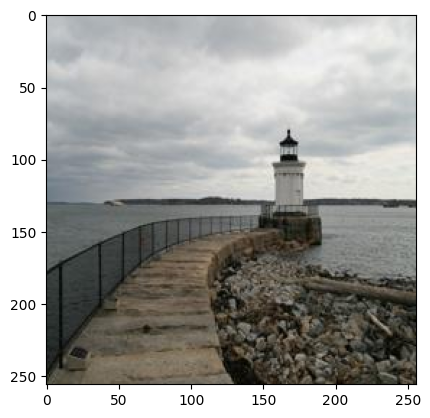

In [ ]:
image_outdoor = cv2.imread('/kaggle/input/indoor-outdoor/indoor-outdoor/outdoor/00000001_147361.jpg')
image_outdoor_rgb = cv2.cvtColor(image_outdoor, cv2.COLOR_BGR2RGB)
plt.imshow(image_outdoor_rgb)

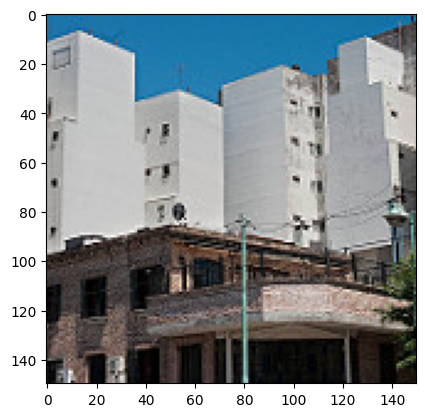

In [ ]:
image_outdoor = cv2.imread('/kaggle/input/indoor-outdoor/indoor-outdoor/outdoor/989_60943.jpg')
image_outdoor_rgb = cv2.cvtColor(image_outdoor, cv2.COLOR_BGR2RGB)
plt.imshow(image_outdoor_rgb)

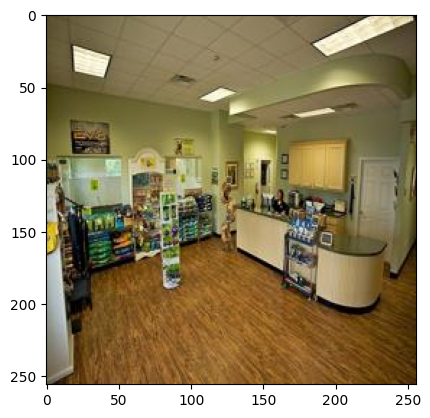

In [ ]:
image_indoor = cv2.imread('/kaggle/input/indoor-outdoor/indoor-outdoor/indoor/00000001_125472.jpg')
image_indoor_rgb = cv2.cvtColor(image_indoor, cv2.COLOR_BGR2RGB)
plt.imshow(image_indoor_rgb)

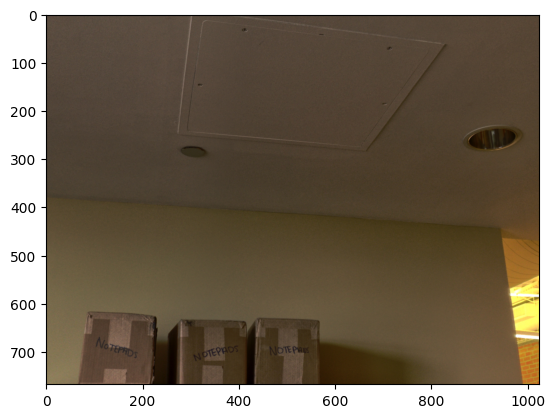

In [ ]:
image_indoor = cv2.imread('/kaggle/input/indoor-outdoor/indoor-outdoor/indoor/00021_00192_indoors_330_030_134632.png')
image_indoor_rgb = cv2.cvtColor(image_indoor, cv2.COLOR_BGR2RGB)
plt.imshow(image_indoor_rgb)

# Препроцессим данные

**Скорее всего, все картинки разных размеров. Нужно сделать какой-то общий resize**

**ResNet18 ожидает изображения 224x224. Интересно попробовать с другим разрешением**

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

indoor_outdoor_data = datasets.ImageFolder(data_dir, transform=transformations)

print(f'Total number of examples: {len(indoor_outdoor_data)}')
indoor_outdoor_data

Total number of examples: 934542


Dataset ImageFolder
    Number of datapoints: 934542
    Root location: /kaggle/input/indoor-outdoor
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

class: 0


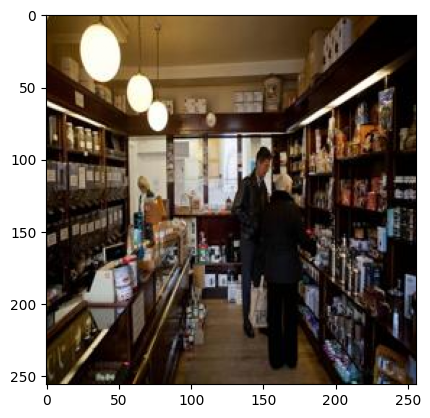

In [ ]:
print(f'class: {indoor_outdoor_data[0][1]}')
plt.imshow(indoor_outdoor_data[0][0].permute(1, 2, 0))

**Делим на train/val в пропорции 70/30**

In [ ]:
def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=42, shuffle=True)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(indoor_outdoor_data)
print(len(datasets['train']))
print(len(datasets['val']))

654179
280363


In [ ]:
train_dataloader = torch.utils.data.DataLoader(datasets['train'], batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(datasets['val'], batch_size=128, shuffle=True)

# Строим модель

**Заменим полносвязный слой в готовой модели**

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)
# criterion = nn.CrossEntropyLoss()

In [ ]:
def new_train(model, optimizer, n_epochs=10):

    model = model.to(device)

    # храним по эпохам
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []

    for epoch in range(n_epochs):

        # обучение
        model.train()
        train_loss, train_accuracy = [], []
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)

            train_loss.append(loss.item())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).cpu().numpy().tolist())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_accuracies.append(np.mean(train_accuracy))
        train_losses.append(np.mean(train_loss))

        # валидация
        model.eval()
        val_loss, val_accuracy = [], []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        val_accuracies.append(np.mean(val_accuracy))
        val_losses.append(np.mean(val_loss))

        print(f'Epoch: {epoch}, train loss: {np.mean(train_loss)}, accuracy: {np.mean(train_accuracy)}')
        print(f'Epoch: {epoch}, val loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

    return {'train_losses': train_losses, 'train_accuracies': train_accuracies,
            'val_losses': val_losses, 'val_accuracies': val_accuracies}

# Обучаем модель

In [ ]:
new_processing = new_train(model, optimizer)

100%|██████████| 2191/2191 [21:55<00:00,  1.67it/s]


Epoch: 0, train loss: 0.0005251258425255752, accuracy: 0.9998991101823813
Epoch: 0, val loss: 1.7488836847916342e-06, accuracy: 1.0


100%|██████████| 2191/2191 [22:11<00:00,  1.65it/s]


Epoch: 1, train loss: 5.592945686424734e-07, accuracy: 1.0
Epoch: 1, val loss: 9.209796795492846e-05, accuracy: 0.9999785991732147


100%|██████████| 2191/2191 [22:25<00:00,  1.63it/s]


Epoch: 2, train loss: 3.776019825915838e-08, accuracy: 1.0
Epoch: 2, val loss: 3.0179780400003304e-11, accuracy: 1.0


100%|██████████| 2191/2191 [22:47<00:00,  1.60it/s]


Epoch: 3, train loss: 1.0933153011158874e-12, accuracy: 1.0
Epoch: 3, val loss: 0.0, accuracy: 1.0


100%|██████████| 2191/2191 [22:34<00:00,  1.62it/s]


Epoch: 4, train loss: 0.0, accuracy: 1.0
Epoch: 4, val loss: 0.0, accuracy: 1.0


 11%|█         | 540/5111 [05:30<46:38,  1.63it/s]


KeyboardInterrupt: 

**Обучается долго, но ждать конца всех эпох смысла нет, потому что модель сходится сразу**

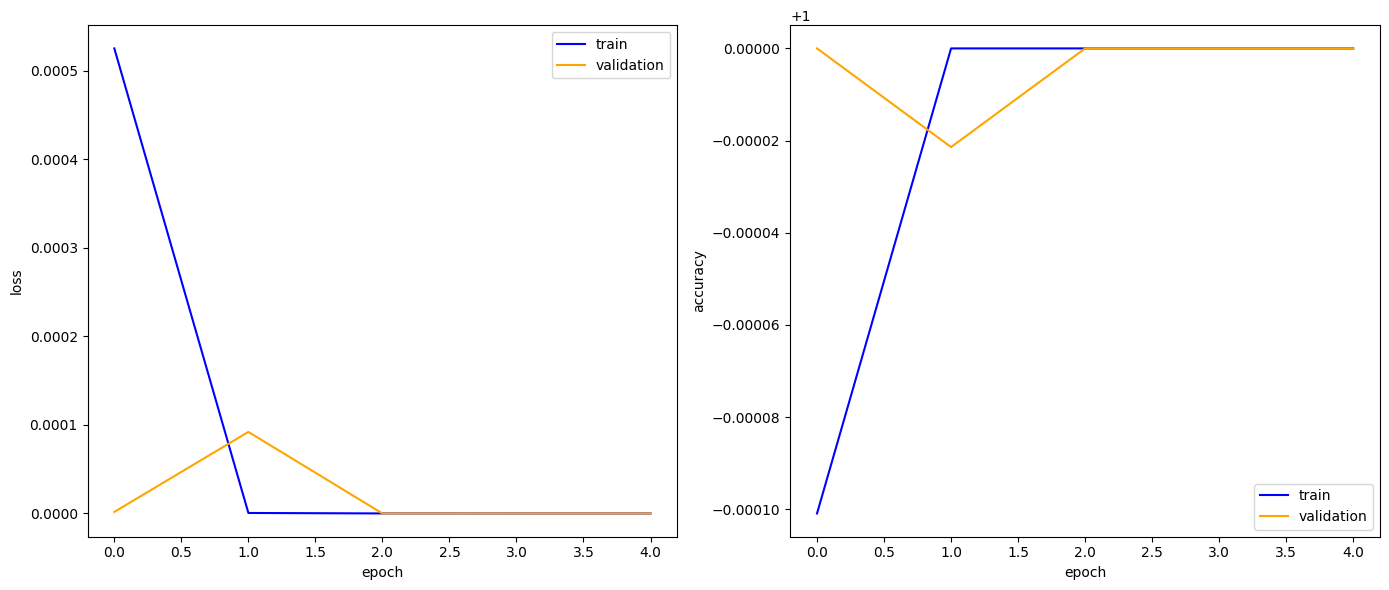

In [ ]:
train_loss = [0.0005251258425255752, 5.592945686424734e-07, 3.776019825915838e-08, 1.0933153011158874e-12, 0.0]
val_loss = [1.7488836847916342e-06, 9.209796795492846e-05, 3.0179780400003304e-11, 0.0, 0.0]
train_acc = [0.9998991101823813, 1.0, 1.0, 1.0, 1.0]
val_acc = [1.0, 0.9999785991732147, 1.0, 1.0, 1.0]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss, color='blue', label='train')
axs[0].plot(val_loss, color='orange', label='validation')
axs[0].set_ylabel('loss')

axs[1].plot(train_acc, color='blue', label='train')
axs[1].plot(val_acc, color='orange', label='validation')
axs[1].set_ylabel('accuracy')

for ax in axs:
    ax.set_xlabel('epoch')
    ax.legend()

plt.tight_layout()

**На оси Y графика accuracy показываются отрицательные числа, но на самом деле это не числа, а выражения типа (1 - accuracy). Т.е. показывается величина, которую необходимо отнять от 1, чтобы получить accuracy соответствующей эпохи**

**Простите, с гиперпараметрами и их влиянием на качество - трудно. У каггла и колаба ограниченные ресурсы**